<a href="https://colab.research.google.com/github/pasquale90/mthesis/blob/master/DenseNet/esc_4.stfts%5Bnew_features%2BDenseNet_121%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Google_drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Import libraries
import os
import pandas as pd
import librosa
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import math
from torch.autograd import Variable
from torchvision import transforms, models


data_path='/content/gdrive/My Drive/dissertation/ESC-50-master/meta/esc50.csv'
audio_path='/content/gdrive/My Drive/dissertation/ESC-50-master/audio/'

In [13]:
mode = 'exp1'
#mode = 'exp2'

In [14]:
if mode == 'exp1':
  feature_path = '/content/gdrive/My Drive/dissertation/ESC-50-master/features/dense121/stfts/exp1/'
if mode == 'exp2':
  feature_path = '/content/gdrive/My Drive/dissertation/ESC-50-master/features/dense121/stfts/exp2/'
print(feature_path)

/content/gdrive/My Drive/dissertation/ESC-50-master/features/dense121/stfts/exp1/


In [15]:
#Import Dataset
esc50 = pd.read_csv(data_path)
audiofiles = os.listdir(audio_path)
print(esc50.shape)
print(len(audiofiles))

(2000, 7)
2000


In [16]:
#store_sorted_class_names, in the same way that are returned from dataset_class in data.py
esc_classes = sorted(esc50['category'].unique())
num_classes = len(esc_classes)
print(num_classes)

50


In [17]:
folds = sorted(esc50['fold'].unique())
print(folds)

[1, 2, 3, 4, 5]


In [18]:
#both extracts the shame shape
if mode == 'exp1':#257x313
  sr=16000
  hop_length=256
  n_fft=512
elif mode=='exp2':#257x313
  sr=32000
  hop_length=512
  n_fft=512
print(sr,hop_length,n_fft)

16000 256 512


In [ ]:
#@title extract_spectograms - various attempts to solve- THIS HAS BEEN KEPT JUST FOR THE RECORD
def extract_features(audio_path, folds, audiofiles, sr, hop_length, n_fft):#df
  '''keep for us8k
  def zero_pad_to_closest(signal,sr, overlap):
    num_zeros=overlap - (len(signal)-(len(signal)//overlap)*overlap)
    zp=np.zeros(num_zeros,dtype=float)
    padded_signal = np.concatenate((signal,zp),axis=0)
    return padded_signal
  '''
  def scale_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 256 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

  def normalize_minus1toplus1(spec,eps=1e-6):
    min = spec.min()
    max = spec.max()
    norm_spec = (2*(spec-min)/((max-min)+eps))-1
    return norm_spec

  def normalize_0to1(spec,eps=1e-6):
    min = spec.min()
    max = spec.max()
    norm_spec = (2*(spec-min)/((max-min)+eps))-1
    return norm_spec
  
  def convert2gray(rgb):#BUUGED
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

  def plot_image(spectogram):
    img = plt.imshow(spectogram)
    plt.axis('off')
    plt.show()

  def RGB_convert(spec):
    rgb = Image.fromarray(spec,'RGB')
    rgb = np.array(rgb)
    return rgb
  def RGB_convert_2(spec):
    rgb = Image.fromarray(spec)
    if rgb.mode!='RGB':
      rgb.mode='RGB'
    rgb = np.array(rgb)
    return rgb
  def RGB_convert_3(spec):
    assert_msg = 'Input shall be a HxWx3 ndarray'
    assert isinstance(np_array, np.ndarray), assert_msg
    assert len(np_array.shape) == 3, assert_msg
    assert np_array.shape[2] == 3, assert_msg
    return img
  def reshape_numpy(rgb):
    rgb = np.reshape(rgb,(rgb.shape[2],
                          rgb.shape[0],
                          rgb.shape[1]))
    return rgb
  def check_rgb(spec):
    img = Image.fromarray(spec)
    if img.mode!='F':
      img.mode='F'
    img = np.array(img)
    return img
    
  features, labels, folders = [], [], []
  for file in tqdm (audiofiles[0:5]):
    #label = int(df.loc[df['filename']==file]['target'].to_string(index=False))
    #folder = int(df.loc[df['filename']==file]['fold'].to_string(index=False))
    name = file.split('.wav')[0]
    label = int(file.split('-')[-1].split('.')[0])
    folder = int(file.split('-')[0])
    #print('name', name)
    #print('folder',folder)
    #print('label',label) 

    raw, fs=librosa.load(audio_path+file, sr=sr, mono=True)
    #print(f'{file} had length {len(raw)}')

    stft=librosa.core.stft(y=raw.astype(float),
                    n_fft=n_fft, 
                    hop_length=hop_length, 
                    window='hann',
                    center=True)
    magnitude = np.abs(stft)
    #to spectogram
    S = librosa.amplitude_to_db(magnitude, ref=np.max )

    #to gray scale
    greyscale = scale_image(S)

    #make it 3D
    image = Image.fromarray(greyscale)
    rgb = image.convert('RGB')
    
    #save image
    rgb.save('/content/test/'+name+'.png')

    
    #grayscale
    #S = scale_image(S)
    #3D
    #S = RGB_convert_2(S)

    #image = Image.fromarray(S) 
    #image.save('/content/test'+name+'.png')

    #plot_image(image)
    

    #new  = plt.imread('/content/test/'+name+'.png')
    #nS = np.asarray(new)
    #print(nS.shape)
    #S = scale_image(S)
    #print(S.min())
    #print(S.max())
    #plot_image(S)
    #image = Image.fromarray(S) 
    
    #normalize
    #S = normalize_0to1(S)
    #scale_image(S)
    #plot_image(S)

    #convert to rgb
    #S = RGB_convert_2(S)
    #plot_image(S)
    #S= check_rgb(S)
    #plot_image(S)

    #S = reshape_numpy(S)
    #print(S.shape)
  '''
    features.append(np.asarray(S))
    labels.append(label)
    folders.append(folder)

  features = np.array(features,dtype=np.float16)                                  
   
  print('features.shape:',features.shape)
  print('labels',len(labels))
  print('folders',len(folders))
  

  return features,labels,folders
  '''
#extract features
extract_features(audio_path, folds, audiofiles, sr, hop_length, n_fft)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [10]:
#@title extract_spectograms - clean
def extract_features(audio_path, folds, audiofiles, sr, hop_length, n_fft):
  
  def scale_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 256 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled
  def plot_image(spectogram):
    img = plt.imshow(spectogram)
    plt.axis('off')
    plt.show()
  features, labels, folders = [], [], []
  for file in tqdm (audiofiles):
    #label = int(df.loc[df['filename']==file]['target'].to_string(index=False))
    #folder = int(df.loc[df['filename']==file]['fold'].to_string(index=False))
    name = file.split('.wav')[0]
    label = int(file.split('-')[-1].split('.')[0])
    folder = int(file.split('-')[0])
    #print('name', name)
    #print('folder',folder)
    #print('label',label) 

    raw, fs=librosa.load(audio_path+file, sr=sr, mono=True)
    #print(f'{file} had length {len(raw)}')

    stft=librosa.core.stft(y=raw.astype(float),
                    n_fft=n_fft, 
                    hop_length=hop_length, 
                    window='hann',
                    center=True)
    magnitude = np.abs(stft)

    #to spectogram 
    S = librosa.amplitude_to_db(magnitude, ref=np.max )

    #to gray scale
    greyscale = scale_image(S)

    #make it 3D
    image = Image.fromarray(greyscale)
    rgb = image.convert('RGB')
    
    #save image
    rgb.save(audio_path+name+'.png')

In [ ]:
#extract features-EXTRACTED FOR MODE1
extract_features(audio_path, folds, audiofiles, sr, hop_length, n_fft)

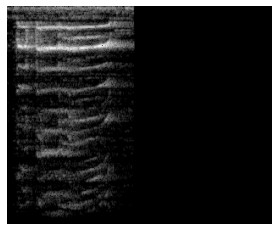

shape: (257, 313, 3)
min: 0
max: 251


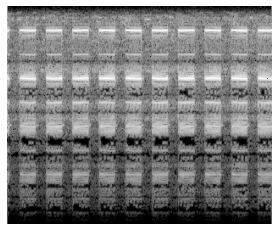

shape: (257, 313, 3)
min: 0
max: 255


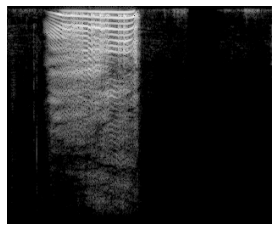

shape: (257, 313, 3)
min: 0
max: 249


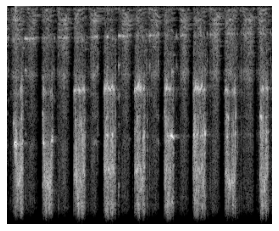

shape: (257, 313, 3)
min: 0
max: 251


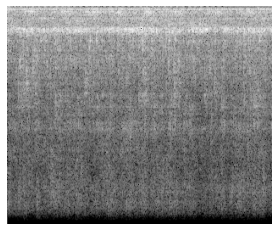

shape: (257, 313, 3)
min: 0
max: 255


In [11]:
#print a few
for feature in (os.listdir(feature_path)[0:5]):
  image = Image.open(feature_path+feature)
  plt.axis('off')
  plt.imshow(image)
  plt.show()
  feature = np.array(image)
  print('shape:',feature.shape) 
  print('min:',feature.min())
  print('max:',feature.max())

In [ ]:
Grayscaled ούτως ώστε να εξυπηρετεί στην εξισσορόπηση των διαφορών βαθμού κβάντισης μεταξύ των datasets και 3 διαστάσεων προκειμένου να συμβαδίζει με τις προδιαγραφές των εισόδων που δέχεται το DenseNet.

Υποσημείωση : Η παραπάνω εντολή #to spectogram στην μέθοδο extract_features μιας και μας δίνει φασματογράφημα, αναρωτιέμαι αν είναι σωστή. Αν τη παραλείψω μου δίνει τις παρακάτω ενδιεκτικές εικόνες.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


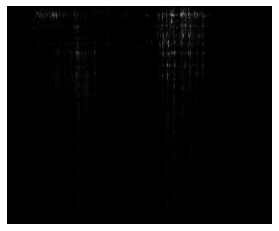

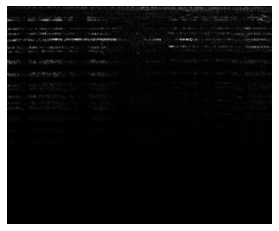

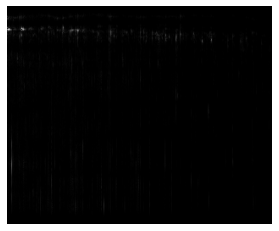

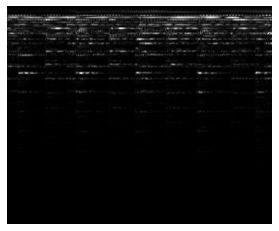

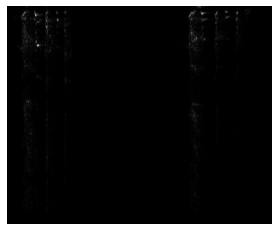

In [20]:
#@title extract_stfts without converting them to spectograms
def extract_features(audio_path, folds, audiofiles, sr, hop_length, n_fft):
  
  def scale_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 256 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled
  def plot_image(spectogram):
    img = plt.imshow(spectogram)
    plt.axis('off')
    plt.show()
  features, labels, folders = [], [], []
  for file in tqdm (audiofiles[0:5]):
    #label = int(df.loc[df['filename']==file]['target'].to_string(index=False))
    #folder = int(df.loc[df['filename']==file]['fold'].to_string(index=False))
    name = file.split('.wav')[0]
    label = int(file.split('-')[-1].split('.')[0])
    folder = int(file.split('-')[0])
    #print('name', name)
    #print('folder',folder)
    #print('label',label) 

    raw, fs=librosa.load(audio_path+file, sr=sr, mono=True)
    #print(f'{file} had length {len(raw)}')

    stft=librosa.core.stft(y=raw.astype(float),
                    n_fft=n_fft, 
                    hop_length=hop_length, 
                    window='hann',
                    center=True)
    magnitude = np.abs(stft)

    #to spectogram -REMOVED
    #S = librosa.amplitude_to_db(magnitude, ref=np.max )

    #to gray scale
    greyscale = scale_image(magnitude)

    #make it 3D
    image = Image.fromarray(greyscale)
    rgb = image.convert('RGB')
    
    plot_image(rgb)
    #save image
    #rgb.save(audio_path+name+'.png')
extract_features(audio_path, folds, audiofiles, sr, hop_length, n_fft)

In [ ]:
'''
con_files = os.listdir(audio_path)
count=0
for file in tqdm(con_files):
  if 'png' in file.split('.'):
    print(file)
    count+=1
    os.rename(audio_path+file,feature_path+file)

    #os.remove('/content/'+file)
print(count)
'''

In [ ]:
extract_features(audio_path, feature_path, folds, audiofiles, sr, hop_length, n_fft)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [20]:
#DATA TRANSFORMS
# Data augmentation and normalization for training
# Just normalization for validation
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
valid_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [21]:
#@title THE DataClass
class Data(Dataset):
  def __init__(self, df, in_col, out_col, mode, path,transform):#(train, 'filename', 'category', mode)
    self.df = df
    self.data = []
    self.labels = []
    
    #for ind in tqdm(range(len(df))):
    for check,ind in tqdm(enumerate(range(len(df)))):
      row = df.iloc[ind]
      image = get_features(row[in_col],path)
      self.data.append(transform(image))#[np.newaxis,...])
      #self.data.append(get_features(row[in_col],path)[np.newaxis,...])
      self.labels.append(row[out_col])
      #print(f' file: {row[in_col]}, of shape: {self.data[check].shape}, has label: {self.labels[check]}, is of type{type(self.data[check])}. It also has min: {torch.min(self.data[check])} and {torch.max(self.data[check])}' )
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):#load data on demand
    return self.data[idx], self.labels[idx]

def get_features(wavname, featurepath):    
  name= featurepath + wavname.split('.')[0]+'.png'
  image=Image.open(name)
  #image=np.array(image)
  #image = image/255.0
  return image

vfold=5 #3,2,1||5
train_data = esc50[esc50['fold']!=vfold]
valid_data = esc50[esc50['fold']==vfold]

train_data = Data(train_data,  'filename', 'target', mode, feature_path,train_transforms)
valid_data = Data(valid_data,  'filename', 'target', mode, feature_path,valid_transforms)
#data iterator
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [22]:
#define device
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
print(device)

cpu


In [ ]:
#@title DenseNet
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

feature_extract = True#False
# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
model = model_ft.to(device)
# Print the model we just instantiated
print(model_ft)

In [21]:
#if feature extract = True, ;only the last Linear Layer ('model.classifier') is kept reducing the params to 51250
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params} total trainable params')

7005106 total parameters.
51250 total trainable params


In [25]:
#@title ResNet
model = models.resnet152(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

for param in model.layer4.parameters():
  param.requires_grad = True
for param in model.avgpool.parameters():
  param.requires_grad = True
for param in model.fc.parameters():
  param.requires_grad = True

model.fc = nn.Linear(2048,num_classes)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params} total trainable params')

58246258 total parameters.
15067186 total trainable params


### ***PREVIOUS MODELS*** 

In [ ]:
#@title model4
#model4
class model4(nn.Module):
  def __init__(self, batch_size, num_cats):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    #
    self.conv9 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.bn9 = nn.BatchNorm2d(512)
    self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
    self.bn10 = nn.BatchNorm2d(512)
    #
    self.ap = nn.AdaptiveAvgPool2d(32)
    self.dense1 = nn.Linear(32*32,128)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(128, num_cats)
  def forward(self, x):
    #print('input',x.shape)
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    #print('1',x.shape)
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    #print('2',x.shape)
    x = F.max_pool2d(x, kernel_size=2) 
    #print('p1',x.shape)
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    #print('3',x.shape)
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    #print('4',x.shape)
    x = F.max_pool2d(x, kernel_size=2)
    #print('p2',x.shape)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    #print('5',x.shape)
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    #print('6',x.shape)
    x = F.max_pool2d(x, kernel_size=2)
    #print('p3',x.shape)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    #print('7',x.shape)
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    #print('8',x.shape)
    '''#
    x = F.max_pool2d(x, kernel_size=2)
    #print('p4',x.shape)
    x = self.conv9(x)
    x = F.relu(self.bn9(x))
    #print('9',x.shape)
    x = self.conv10(x)
    x = F.relu(self.bn10(x))
    #print('10',x.shape)
    '''#
    x = x.view(x.size(0),x.size(1),x.size(2)*x.size(3))
    #print('view',x.shape)
    x = self.ap(x)
    #print('ap',x.shape)
    x = x.view(x.size(0),-1)
    #print('view',x.shape)
    x = F.relu(self.dense1(x))
    #print('dense1',x.shape)
    x = self.dropout(x)
    x = self.dense2(x)
    #print('dense2-output',x.shape)
    return x    
model = model4(batch_size=16, num_cats=50) 

In [ ]:
#@title model4b
#model4b
class model4b(nn.Module):
    def __init__(self,batch_size, num_cats):
        super(model4b, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),#)#,
            nn.MaxPool2d(3, stride=2)) 
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())#,
            #nn.MaxPool2d(3,stride=3))
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())#,
            #nn.MaxPool2d(3,stride=3))   
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2),
            nn.Dropout(0.5))
        self.ap = nn.AdaptiveMaxPool2d(2)
        self.fc = nn.Linear(256*4, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, num_cats)
        self.dropout2 = nn.Dropout(0.1)
        

    def forward(self, x):
        print('input',x.shape)
        x = self.conv1(x)
        print('1',x.shape)
        x = self.conv2(x)
        print('2',x.shape)
        x = self.conv3(x)
        print('3',x.shape)
        x = self.conv4(x)
        print('4',x.shape)
        
        x = self.conv5(x)
        print('5',x.shape)
        '''
        x = self.conv6(x)
        print('6',x.shape)
        
        x = self.conv7(x)
        print('7',x.shape)
        '''
        x = self.ap(x)
        print('ap',x.shape)
        x = x.view(x.shape[0], -1)
        print('view',x.shape)
        x = F.relu(self.fc(self.dropout(x)))
        print('dense1',x.shape)
        x = self.fc2(self.dropout2(x))
        print('dense output',x.shape)
        x = F.log_softmax(x, dim = 1)
        return x

model = model4b(batch_size=16, num_cats=50)

In [ ]:
#@title model4c
#model4c
class model4(nn.Module):
  def __init__(self, batch_size, num_cats):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    #
    self.conv9 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.bn9 = nn.BatchNorm2d(512)
    self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
    self.bn10 = nn.BatchNorm2d(512)
    #
    self.ap = nn.AdaptiveAvgPool2d(32)
    self.dense1 = nn.Linear(32*32,128)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(128, num_cats)
  def forward(self, x):
    print('input',x.shape)
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    print('1',x.shape)
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    print('2',x.shape)
    x = F.max_pool2d(x, kernel_size=2) 
    print('p1',x.shape)
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    print('3',x.shape)
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    print('4',x.shape)
    x = F.max_pool2d(x, kernel_size=2)
    print('p2',x.shape)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    print('5',x.shape)
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    print('6',x.shape)
    x = F.max_pool2d(x, kernel_size=2)
    print('p3',x.shape)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    print('7',x.shape)
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    print('8',x.shape)
    '''#
    x = F.max_pool2d(x, kernel_size=2)
    #print('p4',x.shape)
    x = self.conv9(x)
    x = F.relu(self.bn9(x))
    #print('9',x.shape)
    x = self.conv10(x)
    x = F.relu(self.bn10(x))
    #print('10',x.shape)
    '''#
    x = x.view(x.size(0),x.size(1)*x.size(2)*x.size(3))
    print('view',x.shape)
    x = self.ap(x)
    print('ap',x.shape)
    x = x.view(x.size(0),-1)
    print('view',x.shape)
    x = F.relu(self.dense1(x))
    print('dense1',x.shape)
    x = self.dropout(x)
    x = self.dense2(x)
    print('dense2-output',x.shape)
    return x    
model = model4(batch_size=16, num_cats=50) 

In [ ]:
#@title model4 D 
#@title model4b
#model4b
class model4d(nn.Module):
    def __init__(self,batch_size, num_cats):
        super(model4d, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.conv12 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),#)#,
            nn.MaxPool2d(3, stride=2)) 
        self.conv22 = nn.Sequential(
            nn.Conv2d(32,32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv32 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2 ,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv42 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())#,
            #nn.MaxPool2d(3,stride=3)) 

        
        self.ap = nn.AdaptiveMaxPool2d(2)
        self.fc = nn.Linear(256*4, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, num_cats)
        self.dropout2 = nn.Dropout(0.1)
        

    def forward(self, x):
        #print('input',x.shape)
        x = self.conv1(x)
        #print('1',x.shape)
        x = self.conv12(x)
        #print('12',x.shape)
        x = self.conv2(x)
        #print('2',x.shape)
        x = self.conv22(x)
        #print('22',x.shape)
        x = self.conv3(x)
        #print('3',x.shape)
        x = self.conv4(x)
        #print('4',x.shape)
        x = self.conv42(x)
        #print('42',x.shape)
        x = self.conv5(x)
        #print('5',x.shape)

        '''
        x = self.conv6(x)
        print('6',x.shape)
        
        x = self.conv7(x)
        print('7',x.shape)
        '''
        x = self.ap(x)
        #print('ap',x.shape)
        x = x.view(x.shape[0], -1)
        #print('view',x.shape)
        x = F.relu(self.fc(self.dropout(x)))
        #print('dense1',x.shape)
        x = self.fc2(self.dropout2(x))
        #print('dense output',x.shape)
        x = F.log_softmax(x, dim = 1)
        return x

model = model4d(batch_size=16, num_cats=50)

In [ ]:
#@title model4E
class model4E(nn.Module):
    def __init__(self,batch_size, num_cats):
        super(model4E, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.conv12 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),#)#,
            nn.MaxPool2d(3, stride=2)) 
        self.conv22 = nn.Sequential(
            nn.Conv2d(32,32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv32 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2 ,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv42 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())#,
            #nn.MaxPool2d(3,stride=3)) 

        
        self.ap = nn.AdaptiveMaxPool2d(2)
        self.fc = nn.Linear(256*4, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, num_cats)
        self.dropout2 = nn.Dropout(0.1)
        

    def forward(self, x):
        #print('input',x.shape)
        x = self.conv12(x)
        #print('12',x.shape)
        x = self.conv2(x)
        #print('2',x.shape)
        x = self.conv22(x)
        #print('22',x.shape)
        x = self.conv3(x)
        #print('3',x.shape)
        x = self.conv4(x)
        #print('4',x.shape)
        x = self.conv42(x)
        #print('42',x.shape)
        x = self.conv5(x)
        #print('5',x.shape)

        x = self.ap(x)
        #print('ap',x.shape)
        x = x.view(x.shape[0], -1)
        #print('view',x.shape)
        x = F.relu(self.fc(self.dropout(x)))
        #print('dense1',x.shape)
        x = self.fc2(self.dropout2(x))
        #print('dense output',x.shape)
        x = F.log_softmax(x, dim = 1)
        return x

model = model4E(batch_size=16, num_cats=50)

In [ ]:
#@title model4F
class model4F(nn.Module):
    def __init__(self,batch_size, num_cats):
        super(model4F, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),#)#,
            nn.MaxPool2d(3, stride=2)) 
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2 ,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.conv6 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv7 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())#,
            #nn.MaxPool2d(3,stride=3)) 

        
        self.ap = nn.AdaptiveMaxPool2d(3)
        self.fc = nn.Linear(128*9, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, num_cats)
        self.dropout2 = nn.Dropout(0.1)
        

    def forward(self, x):
        #print('input',x.shape)
        x = self.conv1(x)
        #print('1 ',x.shape)
        x = self.conv2(x)
        #print('2',x.shape)
        x = self.conv3(x)
        #print('3',x.shape)
        x = self.conv4(x)
        #print('4',x.shape)
        x = self.conv5(x)
        #print('5',x.shape)
        x = self.conv6(x)
        #print('6',x.shape)
        x = self.conv7(x)
        #print('7',x.shape)
      
        x = self.ap(x)
        #print('ap',x.shape)
        x = x.view(x.shape[0], -1)
        #print('view',x.shape)
        x = F.relu(self.fc(self.dropout(x)))
        #print('dense1',x.shape)
        x = self.fc2(self.dropout2(x))
        #print('dense output',x.shape)
        x = F.log_softmax(x, dim = 1)
        return x

model = model4F(batch_size=16, num_cats=50)

In [ ]:
#@title model4G?
class model4F(nn.Module):
    def __init__(self,batch_size, num_cats):
        super(model4F, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),#)#,
            nn.MaxPool2d(3, stride=2)) 
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2 ,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.conv6 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2))
        self.conv7 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())#,
            #nn.MaxPool2d(3,stride=3)) 

        
        self.ap = nn.AdaptiveMaxPool2d(3)
        self.fc = nn.Linear(128*9, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, num_cats)
        self.dropout2 = nn.Dropout(0.1)
        

    def forward(self, x):
        print('input',x.shape)
        x = self.conv1(x)
        print('1 ',x.shape)
        x = self.conv2(x)
        print('2',x.shape)
        x = self.conv3(x)
        print('3',x.shape)
        x = self.conv4(x)
        print('4',x.shape)
        x = self.conv5(x)
        print('5',x.shape)
        x = self.conv6(x)
        print('6',x.shape)
        x = self.conv7(x)
        print('7',x.shape)
        #x = self.conv8(x)
        #print('8',x.shape)

        x = self.ap(x)
        print('ap',x.shape)
        x = x.view(x.shape[0], -1)
        print('view',x.shape)
        x = F.relu(self.fc(self.dropout(x)))
        print('dense1',x.shape)
        x = self.fc2(self.dropout2(x))
        print('dense output',x.shape)
        x = F.log_softmax(x, dim = 1)
        return x

model = model4F(batch_size=16, num_cats=50)

In [ ]:
#@title check tensor_sizes of previous models
'''4D
1 torch.Size([16, 16, 257, 431])
12 torch.Size([16, 16, 129, 216])
2 torch.Size([16, 32, 64, 107])
22 torch.Size([16, 32, 64, 107])
3 torch.Size([16, 64, 15, 26])
4 torch.Size([16, 128, 7, 12])
42 torch.Size([16, 128, 4, 6])
5 torch.Size([16, 256, 2, 3])
ap torch.Size([16, 256, 2, 2])
view torch.Size([16, 1024])
dense1 torch.Size([16, 128])
dense output torch.Size([16, 50])
'''
''' 4E
input torch.Size([16, 1, 257, 431])
12 torch.Size([16, 16, 129, 216])
2 torch.Size([16, 32, 64, 107])
22 torch.Size([16, 32, 64, 107])
3 torch.Size([16, 64, 15, 26])
4 torch.Size([16, 128, 7, 12])
42 torch.Size([16, 128, 4, 6])
5 torch.Size([16, 256, 2, 3])
ap torch.Size([16, 256, 2, 2])
'''
'''4F
input torch.Size([16, 1, 257, 431])
1  torch.Size([16, 16, 129, 216])
2 torch.Size([16, 32, 64, 107])
3 torch.Size([16, 32, 32, 54])
4 torch.Size([16, 64, 15, 26])
5 torch.Size([16, 64, 8, 13])
6 torch.Size([16, 128, 3, 6])
7 torch.Size([16, 128, 2, 3])
ap torch.Size([16, 128, 3, 3])
view torch.Size([16, 1152])
dense1 torch.Size([16, 128])
dense output torch.Size([16, 50])
'''

In [27]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5#1#1e-3,
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.Adadelta(model.parameters(), learning_rate)
epochs = 30
train_losses = []
valid_losses = []

#optimizer
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

def train(model, loss_fn, train_loader, valid_loader,
          epochs, optimizer, train_losses, valid_losses, change_lr):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()#set the model to training mode
    batch_losses=[]
    #if change_lr:
     # optimizer = change_lr(optimizer, epoch)
    for i, data in tqdm(enumerate(train_loader)):#performs a step in the train loop 
      x, y = data     
      optimizer.zero_grad()#zero the gradients before updating them
      x = x.to(device, dtype=torch.float32) #init tensor _minibatch(16) of spectograms
      y = y.to(device, dtype=torch.long)  #init tensor _categories' id
      y_hat = model(x) #the equation is the model itself-,model is actually a modeled equation
      loss = loss_fn(y_hat, y)#compute forward loss
      loss.backward() #for alleviating the parameters' loss
      batch_losses.append(loss.item()) #here batch_calc is returned
      optimizer.step()#step of the optimizer-updates the parameters/  batch?mini-batch?stohastic? 
      #print(model.state_dict())
    train_losses.append(batch_losses)

    print()
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    print()
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    #print('debug')
    for i, data in enumerate(valid_loader):
      x, y = data
      #print('x,y')
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      #print('yhat')
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())#allocate the tensor in RAM 
                                  #detatch --> cut computational graph
                                  #cpu --> allocate tensor in RAM
                                  #numpy --> port tensor to numpy
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)#mean of Trues
    
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(params)
    #micro,macro auroc
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy} ')

  #return train_losses,valid_losses,accuracy,trace_y,trace_yhat,batch_losses

In [28]:
#@title ResNet adam 2e-5 { 15067186 } weight_decay=0
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 3.832219333648682

15067186
Epoch - 1 Valid-Loss : 3.5586656284332276 Valid-Accuracy : 0.18 




Epoch - 2 Train-Loss : 3.3048678255081176

15067186
Epoch - 2 Valid-Loss : 3.189631404876709 Valid-Accuracy : 0.2725 




Epoch - 3 Train-Loss : 2.87670184135437

15067186
Epoch - 3 Valid-Loss : 2.8888553047180174 Valid-Accuracy : 0.345 




Epoch - 4 Train-Loss : 2.501436461210251

15067186
Epoch - 4 Valid-Loss : 2.6716090202331544 Valid-Accuracy : 0.385 




Epoch - 5 Train-Loss : 2.1632719242572787

15067186
Epoch - 5 Valid-Loss : 2.506852593421936 Valid-Accuracy : 0.4175 




Epoch - 6 Train-Loss : 1.8508240497112274

15067186
Epoch - 6 Valid-Loss : 2.3818112659454345 Valid-Accuracy : 0.45 




Epoch - 7 Train-Loss : 1.560815441608429

15067186
Epoch - 7 Valid-Loss : 2.2884756088256837 Valid-Accuracy : 0.4475 




Epoch - 8 Train-Loss : 1.2947765755653382

15067186
Epoch - 8 Valid-Loss : 2.2188024616241453 Valid-Accuracy : 0.44 




Epoch - 9 Train-Loss : 1.0562881588935853

15067186
Epoch - 9 Valid-Loss : 2.166398091316223 Valid-Accuracy : 0.4475 




Epoch - 10 Train-Loss : 0.8482789632678032

15067186
Epoch - 10 Valid-Loss : 2.126274838447571 Valid-Accuracy : 0.4525 




Epoch - 11 Train-Loss : 0.6726106432080269

15067186
Epoch - 11 Valid-Loss : 2.097814974784851 Valid-Accuracy : 0.4525 




Epoch - 12 Train-Loss : 0.5286827617883683

15067186
Epoch - 12 Valid-Loss : 2.077603940963745 Valid-Accuracy : 0.4525 




Epoch - 13 Train-Loss : 0.41466579273343085

15067186
Epoch - 13 Valid-Loss : 2.0655939245223998 Valid-Accuracy : 0.455 




Epoch - 14 Train-Loss : 0.326829946488142

15067186
Epoch - 14 Valid-Loss : 2.0612256002426146 Valid-Accuracy : 0.4575 




Epoch - 15 Train-Loss : 0.26003684632480145

15067186
Epoch - 15 Valid-Loss : 2.0573952627182006 Valid-Accuracy : 0.4575 


KeyboardInterrupt: ignored

In [ ]:
#@title Densenet{only last Linear Layer} ADADETA 0.1 { 51250 } 
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 3.9798642802238464

51250
Epoch - 1 Valid-Loss : 3.713022518157959 Valid-Accuracy : 0.0625 




Epoch - 2 Train-Loss : 3.687923913002014

51250
Epoch - 2 Valid-Loss : 3.537735967636108 Valid-Accuracy : 0.14 




Epoch - 3 Train-Loss : 3.514218974113464

51250
Epoch - 3 Valid-Loss : 3.3920792961120605 Valid-Accuracy : 0.175 




Epoch - 4 Train-Loss : 3.3633937430381775

51250
Epoch - 4 Valid-Loss : 3.2668645095825197 Valid-Accuracy : 0.22 




Epoch - 5 Train-Loss : 3.229423077106476

51250
Epoch - 5 Valid-Loss : 3.157830238342285 Valid-Accuracy : 0.26 




Epoch - 6 Train-Loss : 3.1091038727760316

51250
Epoch - 6 Valid-Loss : 3.062016096115112 Valid-Accuracy : 0.28 




Epoch - 7 Train-Loss : 3.0001083254814147

51250
Epoch - 7 Valid-Loss : 2.977232894897461 Valid-Accuracy : 0.285 




Epoch - 8 Train-Loss : 2.900675642490387

51250
Epoch - 8 Valid-Loss : 2.901806478500366 Valid-Accuracy : 0.2875 




Epoch - 9 Train-Loss : 2.809434471130371

51250
Epoch - 9 Valid-Loss : 2.8344147491455076 Valid-Accuracy : 0.29 




Epoch - 10 Train-Loss : 2.7252867722511294

51250
Epoch - 10 Valid-Loss : 2.7739834690093996 Valid-Accuracy : 0.295 




Epoch - 11 Train-Loss : 2.647333334684372

51250
Epoch - 11 Valid-Loss : 2.7196176433563233 Valid-Accuracy : 0.295 




Epoch - 12 Train-Loss : 2.574824209213257

51250
Epoch - 12 Valid-Loss : 2.670561866760254 Valid-Accuracy : 0.305 




Epoch - 13 Train-Loss : 2.5071265470981596

51250
Epoch - 13 Valid-Loss : 2.6261713981628416 Valid-Accuracy : 0.315 




Epoch - 14 Train-Loss : 2.4437017047405245

51250
Epoch - 14 Valid-Loss : 2.5858932971954345 Valid-Accuracy : 0.3225 


In [19]:
#@title Densenet adam 2e-5 { 7.005.106 } with weight_decay=1e-6{forgot to erase}
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 3.9205366659164427

7005106
Epoch - 1 Valid-Loss : 3.7371772384643553 Valid-Accuracy : 0.0775 




Epoch - 2 Train-Loss : 3.4282799553871155

7005106
Epoch - 2 Valid-Loss : 3.5096054458618164 Valid-Accuracy : 0.155 




Epoch - 3 Train-Loss : 3.0281664752960205

7005106
Epoch - 3 Valid-Loss : 3.320786924362183 Valid-Accuracy : 0.2475 




Epoch - 4 Train-Loss : 2.6876800274848938

7005106
Epoch - 4 Valid-Loss : 3.1672942352294924 Valid-Accuracy : 0.275 




Epoch - 5 Train-Loss : 2.410810830593109

7005106
Epoch - 5 Valid-Loss : 3.0435597705841064 Valid-Accuracy : 0.285 




Epoch - 6 Train-Loss : 2.1854776620864866

7005106
Epoch - 6 Valid-Loss : 2.9297914028167726 Valid-Accuracy : 0.3175 




Epoch - 7 Train-Loss : 1.9805801868438722

7005106
Epoch - 7 Valid-Loss : 2.8391348838806154 Valid-Accuracy : 0.35 




Epoch - 8 Train-Loss : 1.7935604429244996

7005106
Epoch - 8 Valid-Loss : 2.7655856227874756 Valid-Accuracy : 0.3625 




Epoch - 9 Train-Loss : 1.623975282907486

7005106
Epoch - 9 Valid-Loss : 2.7111994647979736 Valid-Accuracy : 0.385 




Epoch - 10 Train-Loss : 1.460737442970276

7005106
Epoch - 10 Valid-Loss : 2.6535658645629883 Valid-Accuracy : 0.3925 




Epoch - 11 Train-Loss : 1.3170032727718353

7005106
Epoch - 11 Valid-Loss : 2.5908925247192385 Valid-Accuracy : 0.3925 




Epoch - 12 Train-Loss : 1.1802149039506913

7005106
Epoch - 12 Valid-Loss : 2.546201772689819 Valid-Accuracy : 0.3975 




Epoch - 13 Train-Loss : 1.0628385192155838

7005106
Epoch - 13 Valid-Loss : 2.5125386714935303 Valid-Accuracy : 0.4075 




Epoch - 14 Train-Loss : 0.9591395103931427

7005106
Epoch - 14 Valid-Loss : 2.492003154754639 Valid-Accuracy : 0.4275 




Epoch - 15 Train-Loss : 0.8681709653139115

7005106
Epoch - 15 Valid-Loss : 2.4679959058761596 Valid-Accuracy : 0.4175 




Epoch - 16 Train-Loss : 0.7742479854822159

7005106
Epoch - 16 Valid-Loss : 2.435617198944092 Valid-Accuracy : 0.4125 




Epoch - 17 Train-Loss : 0.6850863632559776

7005106
Epoch - 17 Valid-Loss : 2.4030309915542603 Valid-Accuracy : 0.4075 




Epoch - 18 Train-Loss : 0.6035376754403114

7005106
Epoch - 18 Valid-Loss : 2.383864026069641 Valid-Accuracy : 0.42 




Epoch - 19 Train-Loss : 0.5290614572167397

7005106
Epoch - 19 Valid-Loss : 2.3648857975006106 Valid-Accuracy : 0.4225 




Epoch - 20 Train-Loss : 0.4599578285217285

7005106
Epoch - 20 Valid-Loss : 2.3506816244125366 Valid-Accuracy : 0.41 


KeyboardInterrupt: ignored

# ***Debuggin Previous models***

In [ ]:
#@title 4.stfts model 4F { 593714 }
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 3.918323128223419

593714
Epoch - 1 Valid-Loss : 3.8613107776641846 Valid-Accuracy : 0.0425 




Epoch - 2 Train-Loss : 3.8237665104866028

593714
Epoch - 2 Valid-Loss : 3.798015260696411 Valid-Accuracy : 0.0625 




Epoch - 3 Train-Loss : 3.740152337551117

593714
Epoch - 3 Valid-Loss : 3.73321702003479 Valid-Accuracy : 0.08 




Epoch - 4 Train-Loss : 3.6546802878379823

593714
Epoch - 4 Valid-Loss : 3.6652613830566407 Valid-Accuracy : 0.1025 




Epoch - 5 Train-Loss : 3.568792612552643

593714
Epoch - 5 Valid-Loss : 3.599101982116699 Valid-Accuracy : 0.1175 




Epoch - 6 Train-Loss : 3.4689926290512085

593714
Epoch - 6 Valid-Loss : 3.5320036792755127 Valid-Accuracy : 0.1225 




Epoch - 7 Train-Loss : 3.376815364360809

593714
Epoch - 7 Valid-Loss : 3.4715327167510988 Valid-Accuracy : 0.1375 




Epoch - 8 Train-Loss : 3.282570176124573

593714
Epoch - 8 Valid-Loss : 3.414152994155884 Valid-Accuracy : 0.1575 




Epoch - 9 Train-Loss : 3.1961627221107483

593714
Epoch - 9 Valid-Loss : 3.3585206413269044 Valid-Accuracy : 0.1675 




Epoch - 10 Train-Loss : 3.1037058329582212

593714
Epoch - 10 Valid-Loss : 3.306661205291748 Valid-Accuracy : 0.175 




Epoch - 11 Train-Loss : 3.014302155971527

593714
Epoch - 11 Valid-Loss : 3.256091070175171 Valid-Accuracy : 0.185 




Epoch - 12 Train-Loss : 2.9116188168525694

593714
Epoch - 12 Valid-Loss : 3.2025809192657473 Valid-Accuracy : 0.2025 




Epoch - 13 Train-Loss : 2.8337358355522158

593714
Epoch - 13 Valid-Loss : 3.1577012729644776 Valid-Accuracy : 0.2125 


KeyboardInterrupt: ignored

In [ ]:
#@title 4.stfts model 4D {727522}
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 3.8901558113098145

727522
Epoch - 1 Valid-Loss : 3.7955112648010254 Valid-Accuracy : 0.07 




Epoch - 2 Train-Loss : 3.728636426925659

727522
Epoch - 2 Valid-Loss : 3.6928520584106446 Valid-Accuracy : 0.085 




Epoch - 3 Train-Loss : 3.5992875909805297

727522
Epoch - 3 Valid-Loss : 3.601494140625 Valid-Accuracy : 0.1 


KeyboardInterrupt: ignored

In [ ]:
#@title 4.stfts model3- Comparison with 4 {2.479.150}
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 3.84360958814621

2479150
Epoch - 1 Valid-Loss : 3.6820669078826906 Valid-Accuracy : 0.125 


KeyboardInterrupt: ignored

In [ ]:
#4bstfts {1712146}
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch - 1 Train-Loss : 3.895029299259186

1712146
Epoch - 1 Valid-Loss : 3.8227316093444825 Valid-Accuracy : 0.0375 




Epoch - 2 Train-Loss : 3.7863835072517396

1712146
Epoch - 2 Valid-Loss : 3.7506820487976076 Valid-Accuracy : 0.0625 




Epoch - 3 Train-Loss : 3.7041173005104064

1712146
Epoch - 3 Valid-Loss : 3.6852589511871336 Valid-Accuracy : 0.0825 




Epoch - 4 Train-Loss : 3.6216666984558104

1712146
Epoch - 4 Valid-Loss : 3.6157439041137693 Valid-Accuracy : 0.0925 




Epoch - 5 Train-Loss : 3.5316547417640685

1712146
Epoch - 5 Valid-Loss : 3.546539783477783 Valid-Accuracy : 0.1225 


KeyboardInterrupt: ignored